In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import sklearn.ensemble
import sklearn.linear_model
import sklearn.tree

from copy import deepcopy

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями

Загрузим датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмем из него первые 10к объектов, оставим только вещественные признаки, а пропуски заменим нулями. Разобьем выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оценим качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [2]:
FILE_NAME= 'train.csv'
COUNT_OBJECTS = 10000

data = pd.read_csv(FILE_NAME, nrows=COUNT_OBJECTS)
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [3]:
data.shape

(10000, 133)

In [4]:
target = data["target"]
target.value_counts()

1    7562
0    2438
Name: target, dtype: int64

In [5]:
data.dtypes.value_counts()

float64    108
object      19
int64        6
dtype: int64

In [6]:
all_numerical_column_names = list(filter(lambda elem : data[elem].dtype == 'float64',  data.columns))

In [7]:
num_data = data.loc[:, all_numerical_column_names].fillna(0)
num_data.head()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v120,v121,v122,v123,v124,v126,v127,v128,v130,v131
0,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,...,1.059603,0.803572,8.000000,1.989780,0.035754,1.804126,3.113719,2.024285,0.636365,2.857144
1,0.000000,0.000000,0.000000,9.191265,0.000000,0.000000,2.301630,0.000000,1.312910,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.598896,0.000000,0.000000,1.957825,0.000000,0.000000
2,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,...,2.138728,2.238806,9.333333,2.477596,0.013452,1.773709,3.922193,1.120468,0.883118,1.176472
3,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,...,1.166281,1.956521,7.018256,1.812795,0.002267,1.415230,2.954381,1.990847,1.677108,1.034483
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050328,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
target = data['target']

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(num_data, target, train_size=0.7, random_state=999)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

model_DT = DecisionTreeClassifier(max_depth=10)
model_DT_cross = cross_val_score(model_DT, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_DT_cross))

0.7154298453457607


In [11]:
# BaggingClassifier со 100 деревьями
from sklearn.ensemble import BaggingClassifier

model_Bagging = BaggingClassifier(n_estimators=100, n_jobs=-1)
model_Bagging_cross = cross_val_score(model_Bagging, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_Bagging_cross))

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklear

0.7468566019897812


In [114]:
# RandomForestClassifier со 100 деревьями

from sklearn.ensemble import RandomForestClassifier

model_Forest = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
%timeit model_Forest_cross = cross_val_score(model_Forest, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_Forest_cross))


7.41 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.7531428470684943


#### Число деревьев в случайном лесе
В этой задаче рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

Переберем значения от 20 до 1000-5000 деревьев с шагом 50, посчитаем accuracy на тестовой выборке для каждого числа деревьев и построем график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 70 + \ldots + 5000$ деревьев, но можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [13]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

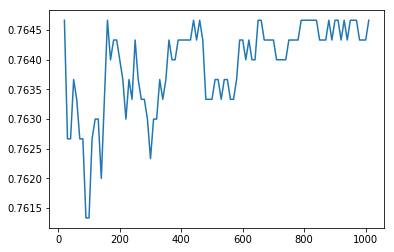

In [14]:
trees_num = 1020
model_Forest = RandomForestClassifier(max_depth=10, n_jobs=-1, warm_start=True)
accuracies = []
for i in range(20, trees_num, 10):
    model_Forest.set_params(n_estimators=i)
    # x_train, x_test, y_train, y_test
    model_Forest.fit(x_train, y_train)
    y_pred = model_Forest.predict(x_test)
    r = accuracy_score(y_test, y_pred)
    accuracies.append(r)

plt.plot([i for i in range(20, trees_num, 10)], accuracies)

#### Обучение градиентного бустинга

А теперь попробуем обучить на тех же данных catboost — одну из реализаций градиентного бустинга. Подберем параметры на обучающем множестве с помощью кросс-валидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров). 

In [15]:
from catboost import CatBoostClassifier

In [16]:
model_Cat = CatBoostClassifier(iterations=700, verbose=False, thread_count=4)
model_Cat_cross = cross_val_score(model_Cat, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_Cat_cross))


Learning rate set to 0.0356
Learning rate set to 0.035602
Learning rate set to 0.035602
0.7604286228672893


In [23]:
x_train, x_test, y_train, y_test = train_test_split(num_data, target, train_size=0.7, random_state=999)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [24]:
# metrics
from sklearn.metrics import f1_score, recall_score, precision_score

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавим категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки (готово)
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный) (готово)
* как счетчики со сглаживанием (не понял что это. Можно ссылку?)

1) Подберем в каждом из случаев оптимальные параметры метода. 

Должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? 
Ответ: Чем больше признаков, тем больше глубина.

Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Меняется в сторону уменьшения.

In [27]:
FILE_NAME = 'train.csv'
COUNT_OBJECTS = 10000
data = pd.read_csv(FILE_NAME, nrows=COUNT_OBJECTS)

target = data["target"]
data = data.drop(["target"], axis=1)

data.dtypes.value_counts()

float64    108
object      19
int64        5
dtype: int64

In [92]:
# Маски по заголовкам
all_numerical_column_names = list(filter(lambda elem : data[elem].dtype == 'float64',  data.columns))
all_int_column_names = list(filter(lambda elem : data[elem].dtype == 'int64',  data.columns))
all_object_column_names = list(filter(lambda elem : data[elem].dtype == 'object',  data.columns))

# Разбивка data по типам и заполнение пропусков
num_data = data.loc[:, all_numerical_column_names].fillna(0)
int_data = data.loc[:, all_int_column_names].fillna(-1)
obj_data = data.loc[:, all_object_column_names].fillna('0')

In [102]:
from sklearn.preprocessing import OneHotEncoder

# Применим OneHoteEncoding только для категориальных целочисленных признаков
ohencoder = OneHotEncoder(sparse = True)
ohencoded_int_data = ohencoder.fit_transform(int_data)
ohencoded_int_data

<10000x10040 sparse matrix of type '<class 'numpy.float64'>'
	with 50000 stored elements in Compressed Sparse Row format>

In [103]:
from sklearn import preprocessing

# Применим LabelEncoder только для данных типа object
le = preprocessing.LabelEncoder()
le_obj_data = pd.DataFrame()
for feature in obj_data.columns:
    le_obj_data[feature]=le.fit_transform(obj_data[feature])
le_obj_data.head()

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,3,4467,2,3,1,2,6,60,2,2,1,3,4,0,4,1,15,0,22
1,3,2103,2,3,1,4,6,72,0,2,1,3,3,1,1,0,21,16,7
2,3,1926,4,0,1,2,5,13,0,0,1,1,4,6,2,1,19,0,6
3,3,424,3,3,2,2,7,34,0,2,1,3,1,1,1,1,10,0,64
4,3,2187,4,0,1,7,7,0,2,2,1,3,2,6,2,0,20,16,89


In [110]:
# Объединяем значения в общий датафрэйм
X = pd.concat([num_data, pd.DataFrame(ohencoded_int_data.todense()), le_obj_data], axis=1)
X.head()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,...,2,1,3,4,0,4,1,15,0,22
1,0.000000,0.000000,0.000000,9.191265,0.000000,0.000000,2.301630,0.000000,1.312910,0.000000,...,2,1,3,3,1,1,0,21,16,7
2,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,...,0,1,1,4,6,2,1,19,0,6
3,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,...,2,1,3,1,1,1,1,10,0,64
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050328,0.000000,...,2,1,3,2,6,2,0,20,16,89


In [111]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, target, train_size=0.7, random_state=999)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [115]:
model_Forest = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
%timeit model_Forest_cross = cross_val_score(model_Forest, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_Forest_cross))



6.81 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.7531428470684943


In [1]:
'''
    1) Модель без категориальных признаков
    7.41 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    0.7531428470684943
    
    2) Модель с векторизованными категориальными признаками (OHT sparse=True)
    6.81 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    0.7531428470684943

'''



'\n    1) Модель без категориальных признаков\n    7.41 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)\n    0.7531428470684943\n    \n    2) Модель с векторизованными категориальными признаками (OHT sparse=True)\n    6.81 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)\n    0.7531428470684943\n\n'

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import sklearn.ensemble
import sklearn.linear_model
import sklearn.tree
from tqdm import tqdm_notebook
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder

FILE_NAME = 'train.csv'
COUNT_OBJECTS = 10000
data = pd.read_csv(FILE_NAME)
target = data["target"]
data = data.drop(["target"], axis=1)
# Маски по заголовкам
all_numerical_column_names = list(filter(lambda elem : data[elem].dtype == 'float64',  data.columns))
all_int_column_names = list(filter(lambda elem : data[elem].dtype == 'int64',  data.columns))
all_object_column_names = list(filter(lambda elem : data[elem].dtype == 'object',  data.columns))

# Разбивка data по типам и заполнение пропусков
num_data = data.loc[:, all_numerical_column_names].fillna(0)
int_data = data.loc[:, all_int_column_names].fillna(-1)
obj_data = data.loc[:, all_object_column_names].fillna('0')


In [101]:
from sklearn import preprocessing

def obj_to_int(df):
    le_obj_data = pd.DataFrame()
    for feature in df.columns:
        le = preprocessing.LabelEncoder()
        le_obj_data[feature]=le.fit_transform(df[feature])
    
    return le_obj_data

# Применим LabelEncoder только для данных типа object
le_obj_data = obj_to_int(obj_data)

In [102]:
# Объединяем значения в общий датафрэйм
X = pd.concat([num_data, int_data, le_obj_data], axis=1)
X.head()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,...,4,1,3,4,1,5,1,15,0,22
1,0.000000,0.000000,0.000000,9.191265,0.000000,0.000000,2.301630,0.000000,1.312910,0.000000,...,4,1,3,3,2,2,0,21,18,7
2,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,...,1,1,1,4,7,3,1,19,0,6
3,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,...,4,1,3,1,2,2,1,10,0,65
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050328,0.000000,...,4,1,3,2,7,3,0,20,18,90


In [84]:
X.dtypes.value_counts() # Проверка типов и количества данных

float64    108
int64       24
dtype: int64

In [85]:
X = X.drop(['ID', 'v22'], axis=1)

In [86]:
#  счетчики со сглаживанием
def counts(column, target, constanta):
    c = constanta
    count = dict()
    for item in (np.unique(column)):
        count[item]=(((column == item) & (target == 1)).sum() + c)/((column == item).sum() + c)
    return count

In [87]:
def pre_processing(df, target, encoding_type=None):
    
    if encoding_type is 'OHE':
        mask = list(filter(lambda elem : df[elem].dtype == 'int64',  df.columns))
        ohencoder = OneHotEncoder(categorical_features=[x in mask for x in df.columns])
        X_encoded = ohencoder.fit_transform(df)
        result = pd.DataFrame(X_encoded.todense(), index=df.index)
        X_train, X_test, y_train, y_test = train_test_split(result, target, test_size = 0.30, random_state = 17)
        return X_train, X_test, y_train, y_test
    
    elif encoding_type == 'LE':
        X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.30, random_state = 17)
        return X_train, X_test, y_train, y_test
                                                            
    elif encoding_type == 'counts':
        categorical_columns = list(filter(lambda elem : df[elem].dtype == 'int64',  df.columns))
        X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.30, random_state = 17)
        for column in categorical_columns:
            count_dict = counts(X_train[column], y_train, 1)
            X_train[column] = X_train[column].map(count_dict)
            X_test[column] = X_test[column].map(count_dict)
        return X_train, X_test, y_train, y_test
                
        
        # Применить counts(вызывать из препроцессинга) к категориальным столбцам 
        # X (проитеррироваться по категориальным столбцам)
        
        

In [88]:
X_2 = X.copy()
X_train, X_test, y_train, y_test = pre_processing(X_2, target, encoding_type='counts')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [89]:
# X_train, X_test, y_train, y_test
X_train.dtypes.value_counts()

float64    130
dtype: int64

In [90]:
'''
    TODO: 
    1) Применить counts(вызывать из препроцессинга) к категориальным столбцам X(проитеррироваться по категориальным столбцам)
    2) получаем словари значений счетчиков (словари с вероятностями)
    3) применяем на столбцах признаков X. Меняем инты и обджекты на словари с вероятностями
    4) Построить три раза деревья(время, валскор) на голом Х, на Х+ОНТ и на Х+счетчики(каунтс).
'''

'\n    TODO: \n    1) Применить counts(вызывать из препроцессинга) к категориальным столбцам X(проитеррироваться по категориальным столбцам)\n    2) получаем словари значений счетчиков (словари с вероятностями)\n    3) применяем на столбцах признаков X. Меняем инты и обджекты на словари с вероятностями\n    4) Построить три раза деревья(время, валскор) на голом Х, на Х+ОНТ и на Х+счетчики(каунтс).\n'

In [91]:
from catboost import CatBoostClassifier

for method in ['LE', 'OHE', 'counts']:
    x_train, x_test, y_train, y_test = pre_processing(X, target, encoding_type=method)
    model_Cat = CatBoostClassifier(iterations=200, verbose=False, thread_count=4)
    model_Cat_cross = cross_val_score(model_Cat, x_train, y_train, cv=2, n_jobs=-1, scoring='accuracy')
    print(method, np.mean(model_Cat_cross))


Learning rate set to 0.199676
Learning rate set to 0.199676
LE 0.777704188743377
Learning rate set to 0.199676
Learning rate set to 0.199676
OHE 0.7783914825552334


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Learning rate set to 0.199676
Learning rate set to 0.199676
counts 0.7775542337298811


In [106]:
a = list(filter(lambda elem : X[elem].dtype == 'int64',  X.columns))
categorical_features=[i for i, x in enumerate(X.columns) if x in a]

In [110]:
x_train, x_test, y_train, y_test = pre_processing(X, target, encoding_type='LE')
model_Cat = CatBoostClassifier(iterations=200, verbose=False, thread_count=4)
model_Cat.fit(x_train, y_train, cat_features=categorical_features)
print('LE', model_Cat.score(x_test, y_test))


Learning rate set to 0.246178
LE <bound method CatBoostClassifier.score of <catboost.core.CatBoostClassifier object at 0x11a9b3a90>>


0.7929848091669826